In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [2]:
# Step 1: Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 2: Define image transformations (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize all images to 224x224
    transforms.ToTensor(),           # Convert PIL image to PyTorch Tensor
    transforms.Normalize([0.5], [0.5])  # Optional: normalize (good for grayscale images)
])

# Step 3: Define dataset paths
train_path = '/Users/rohithadhitya/Downloads/MRI/Training'
test_path = '/Users/rohithadhitya/Downloads/MRI/Testing'

# Step 4: Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Step 5: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Optional: check class names
print("Classes:", train_dataset.classes)

# Step 6: Example - Display a batch
data_iter = iter(train_loader)
images, labels = next(data_iter)
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [3]:
class_names = train_dataset.classes

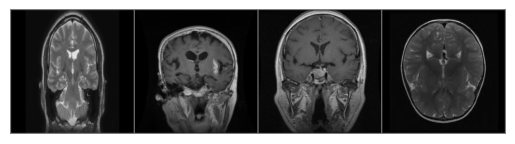

Labels: tensor([2, 0, 3, 2])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if you used Normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Show a few images
imshow(torchvision.utils.make_grid(images[:4]))
print('Labels:', labels[:4])


In [5]:
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_class_distribution_plot(dataset, dataset_name):
    # Get labels (class indices)
    class_indices = dataset.targets  # For torchvision.datasets.ImageFolder
    class_names = dataset.classes

    # Count number of images per class
    class_counts = dict(collections.Counter(class_indices))

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Class': [class_names[i] for i in class_counts.keys()],
        'Count': list(class_counts.values())
    })

    # Plot using seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Count", y="Class", data=df, palette="viridis")
    plt.title(f"Class Distribution - {dataset_name}", fontsize=16)
    plt.xlabel("Number of Samples")
    plt.ylabel("Class")
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()


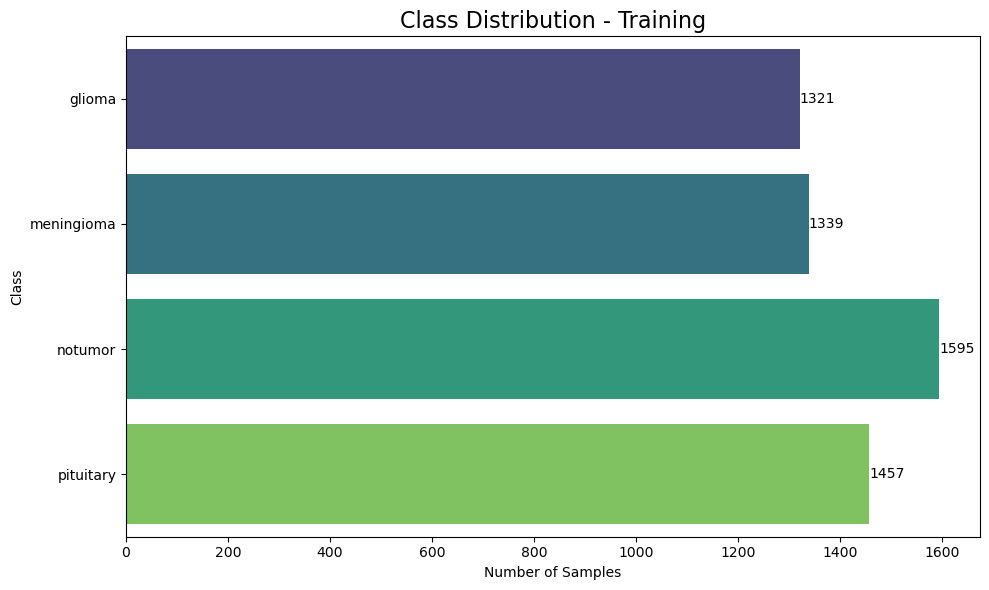

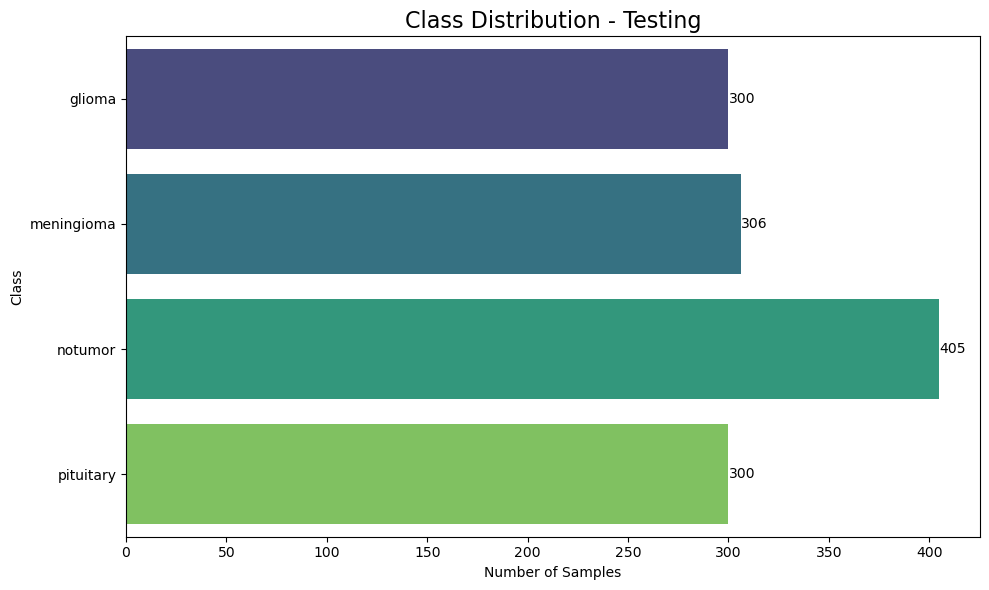

In [6]:
create_class_distribution_plot(train_dataset, "Training")
create_class_distribution_plot(test_dataset, "Testing")

In [7]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # approximate zoom
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Simple transform for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Apply to datasets
train_dataset = datasets.ImageFolder('/Users/rohithadhitya/Downloads/MRI/Training', transform=train_transform)
test_dataset = datasets.ImageFolder('/Users/rohithadhitya/Downloads/MRI/Testing', transform=test_transform)

# Loaders stay the same
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

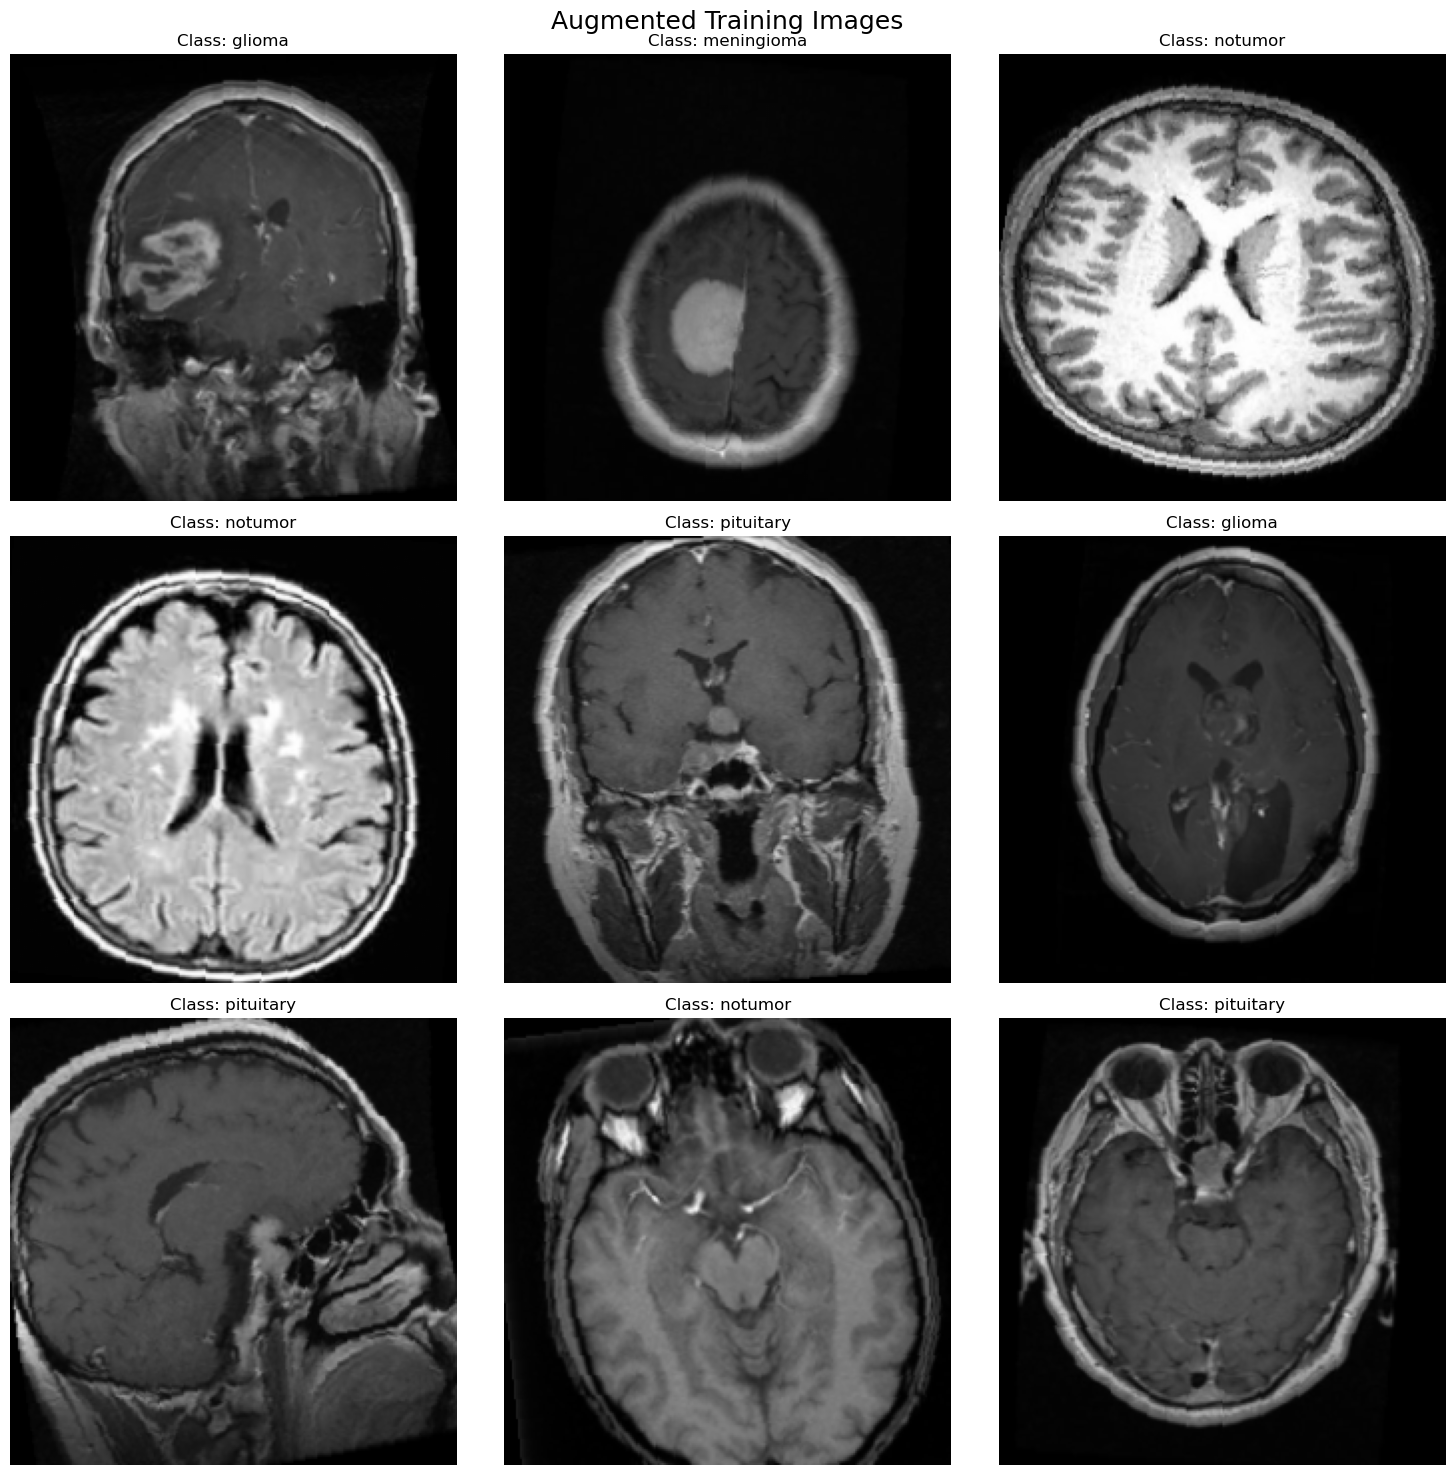

In [8]:
# Get one batch from the loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Unnormalize images
images = images * 0.5 + 0.5  # since we used Normalize([0.5], [0.5])

# Plot 9 images
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(f"Class: {train_dataset.classes[labels[i]]}")
    plt.axis('off')

plt.suptitle("Augmented Training Images", fontsize=18)
plt.tight_layout()
plt.show()

In [9]:
print(torch.backends.mps.is_available())

True


In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f"Using device: {device}")

Using device: mps


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(NNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(224 * 224 * 3, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [12]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    history = {'train_loss': [], 'train_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        scheduler.step(train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    return history


In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))


Epoch [1/10] Train Loss: 0.8238, Train Acc: 0.6875
Epoch [2/10] Train Loss: 0.7246, Train Acc: 0.7311
Epoch [3/10] Train Loss: 0.6926, Train Acc: 0.7351
Epoch [4/10] Train Loss: 0.6708, Train Acc: 0.7511
Epoch [5/10] Train Loss: 0.6557, Train Acc: 0.7523
Epoch [6/10] Train Loss: 0.6210, Train Acc: 0.7630
Epoch [7/10] Train Loss: 0.6211, Train Acc: 0.7649
Epoch [8/10] Train Loss: 0.6010, Train Acc: 0.7740
Epoch [9/10] Train Loss: 0.5769, Train Acc: 0.7831
Epoch [10/10] Train Loss: 0.5859, Train Acc: 0.7740


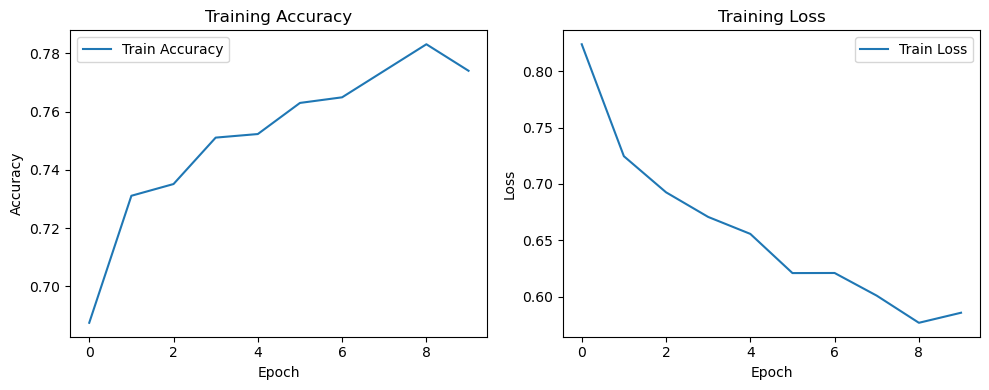

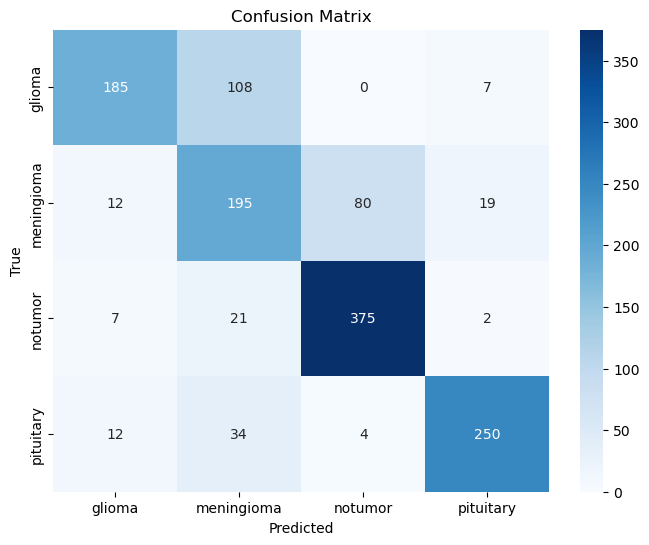


Classification Report:

              precision    recall  f1-score   support

      glioma       0.86      0.62      0.72       300
  meningioma       0.54      0.64      0.59       306
     notumor       0.82      0.93      0.87       405
   pituitary       0.90      0.83      0.87       300

    accuracy                           0.77      1311
   macro avg       0.78      0.75      0.76      1311
weighted avg       0.78      0.77      0.77      1311



In [15]:
# Model
nn_model = NNModel(num_classes=len(class_names)).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

# Train
history_nn = train_model(nn_model, train_loader, criterion, optimizer, scheduler, num_epochs=10)

# Plot metrics
plot_history(history_nn)

# Evaluate
evaluate_model(nn_model, test_loader, class_names)


In [16]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc(x)
        return x


In [17]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=40):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [18]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    history = {'train_loss': [], 'train_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        scheduler.step(train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    return history


In [19]:
model = CNNModel(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

history = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10)


/Users/rohithadhitya/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] Train Loss: 0.5261, Train Acc: 0.7952
Epoch [2/10] Train Loss: 0.3622, Train Acc: 0.8640
Epoch [3/10] Train Loss: 0.2771, Train Acc: 0.9007
Epoch [4/10] Train Loss: 0.2307, Train Acc: 0.9133
Epoch [5/10] Train Loss: 0.1867, Train Acc: 0.9324
Epoch [6/10] Train Loss: 0.1718, Train Acc: 0.9363
Epoch [7/10] Train Loss: 0.1430, Train Acc: 0.9463
Epoch [8/10] Train Loss: 0.1131, Train Acc: 0.9580
Epoch [9/10] Train Loss: 0.1164, Train Acc: 0.9578
Epoch [10/10] Train Loss: 0.0864, Train Acc: 0.9681


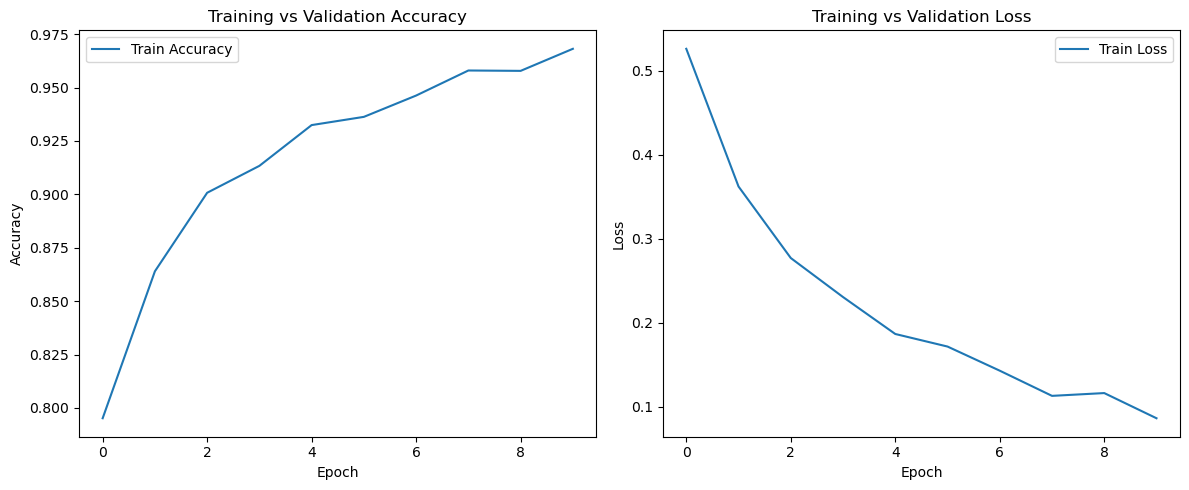

In [20]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    #plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    #plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


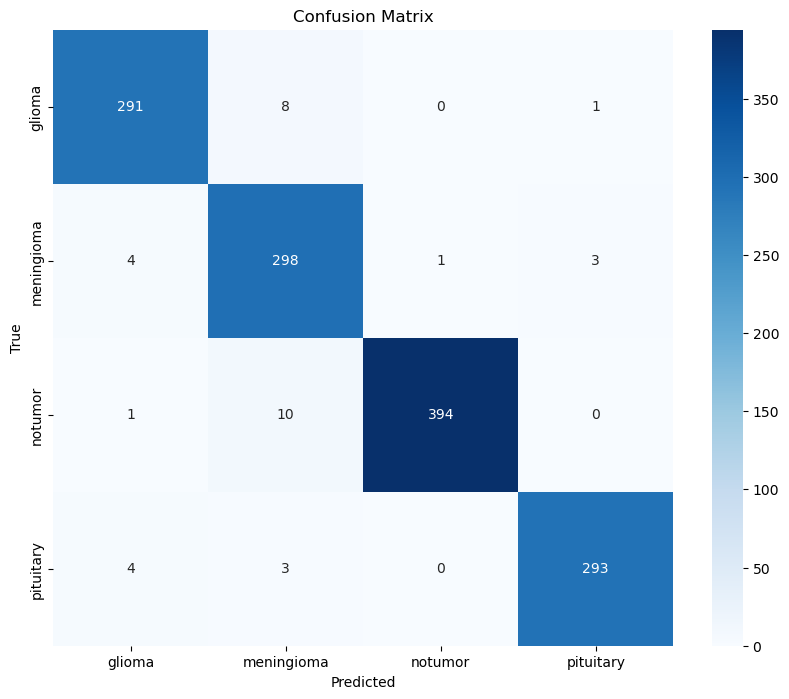


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       300
  meningioma       0.93      0.97      0.95       306
     notumor       1.00      0.97      0.98       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [21]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

evaluate_model(model, test_loader, class_names)


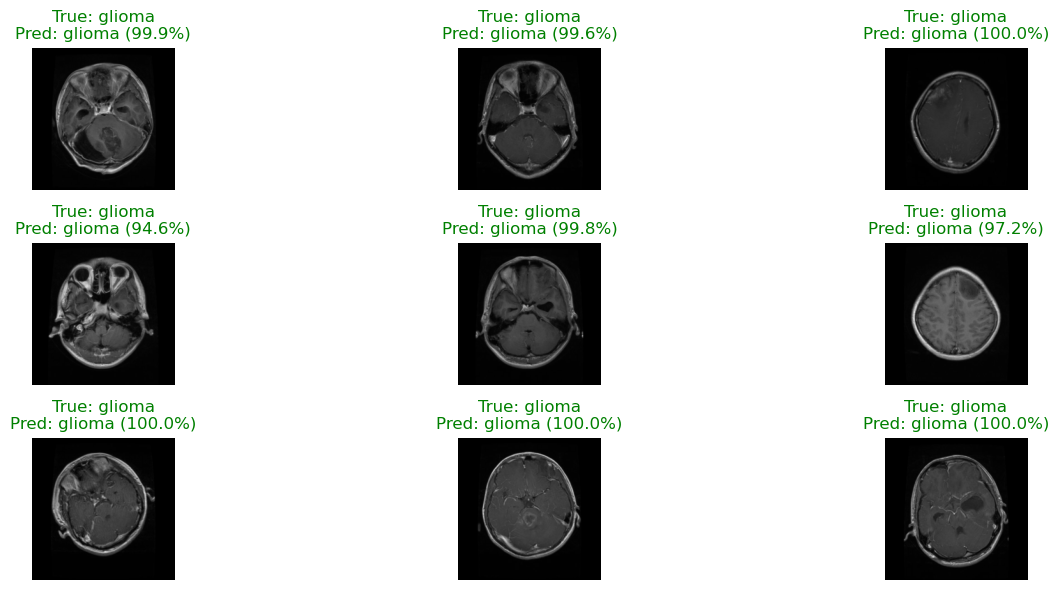

In [22]:
def visualize_predictions(model, test_loader, class_names):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

    images = images.cpu() * 0.5 + 0.5  # unnormalize

    plt.figure(figsize=(15, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        conf = probs[i][preds[i]].item() * 100
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label} ({conf:.1f}%)", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, class_names)


In [23]:
from torchvision import models


In [24]:
# Load pretrained ResNet18
resnet_model = models.resnet18(pretrained=True)

for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the final FC layer for 4 classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 4)

# Move to device
resnet_model = resnet_model.to(device)


/Users/rohithadhitya/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rohithadhitya/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

history_resnet = train_model(resnet_model, train_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch [1/10] Train Loss: 0.5655, Train Acc: 0.8097
Epoch [2/10] Train Loss: 0.4260, Train Acc: 0.8493
Epoch [3/10] Train Loss: 0.3881, Train Acc: 0.8596
Epoch [4/10] Train Loss: 0.3676, Train Acc: 0.8655
Epoch [5/10] Train Loss: 0.3472, Train Acc: 0.8755
Epoch [6/10] Train Loss: 0.3414, Train Acc: 0.8773
Epoch [7/10] Train Loss: 0.3304, Train Acc: 0.8783
Epoch [8/10] Train Loss: 0.3130, Train Acc: 0.8843
Epoch [9/10] Train Loss: 0.3132, Train Acc: 0.8857
Epoch [10/10] Train Loss: 0.3071, Train Acc: 0.8871


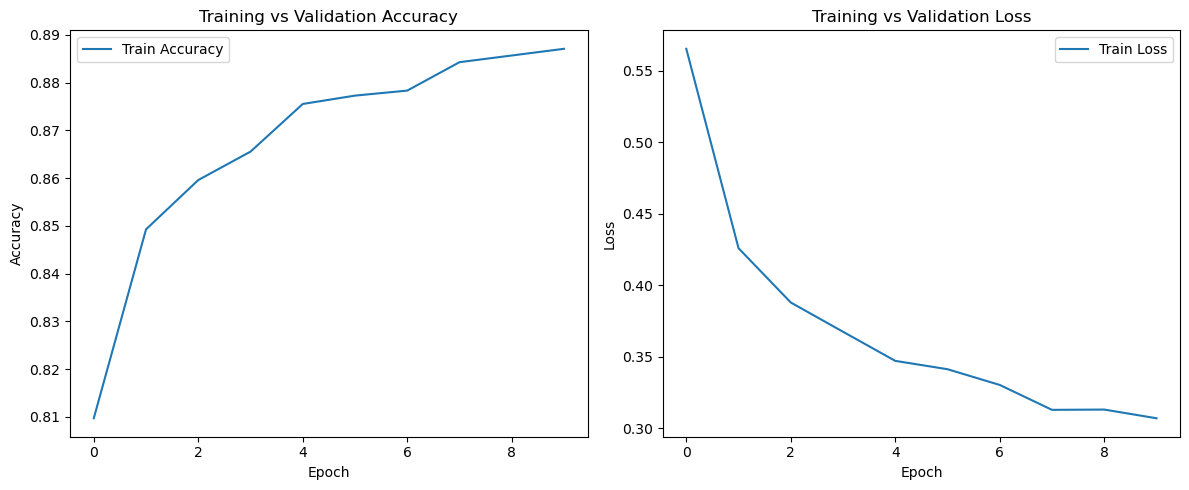

In [28]:
plot_history(history_resnet)

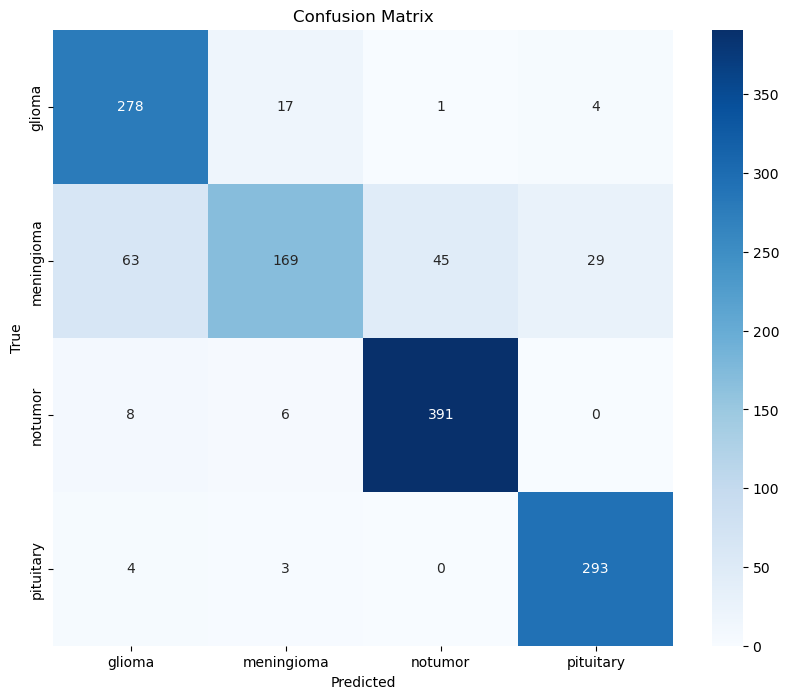


Classification Report:
              precision    recall  f1-score   support

      glioma       0.79      0.93      0.85       300
  meningioma       0.87      0.55      0.67       306
     notumor       0.89      0.97      0.93       405
   pituitary       0.90      0.98      0.94       300

    accuracy                           0.86      1311
   macro avg       0.86      0.86      0.85      1311
weighted avg       0.86      0.86      0.85      1311



In [29]:
evaluate_model(resnet_model, test_loader, class_names)

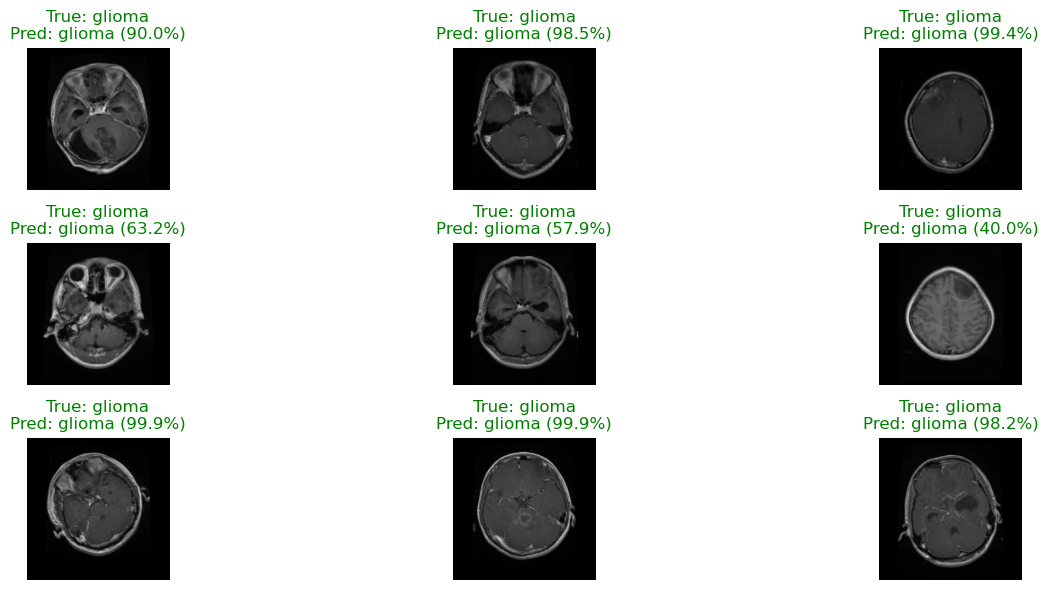

In [30]:
visualize_predictions(resnet_model, test_loader, class_names)

In [31]:
def compare_histories(h1, h2, h3, labels=['CNN', 'NN', 'ResNet']):
    plt.figure(figsize=(14, 5))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(h1['train_acc'], label=f'{labels[0]} Train Acc')
    plt.plot(h2['train_acc'], label=f'{labels[1]} Train Acc')
    plt.plot(h3['train_acc'], label=f'{labels[2]} Train Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.legend()

    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(h1['train_loss'], label=f'{labels[0]} Train Loss')
    plt.plot(h2['train_loss'], label=f'{labels[1]} Train Loss')
    plt.plot(h3['train_loss'], label=f'{labels[2]} Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()


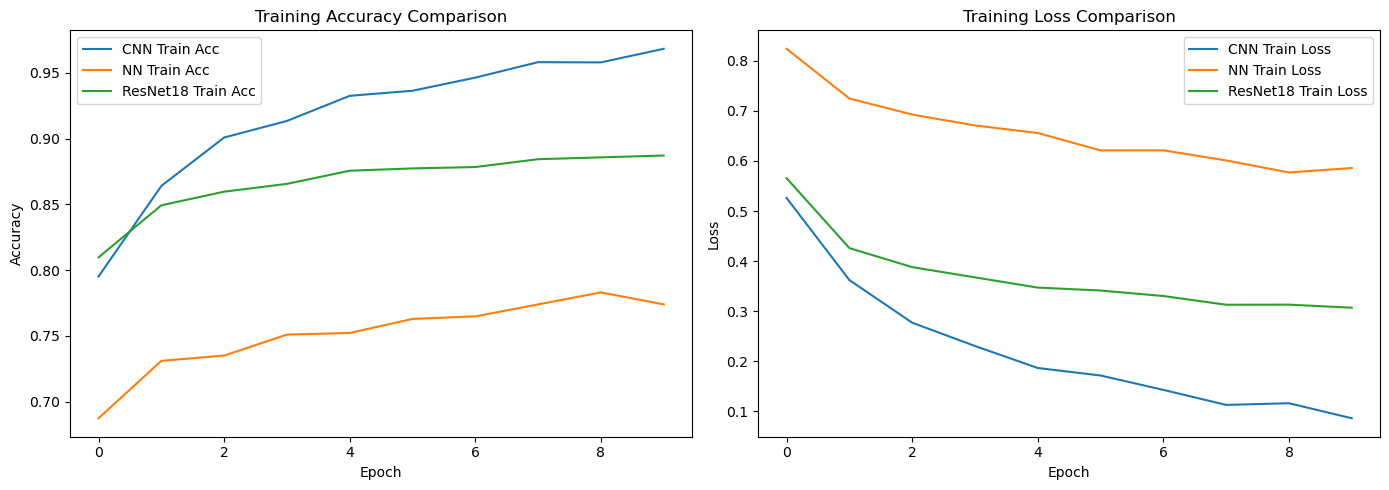

In [33]:
compare_histories(history, history_nn, history_resnet, labels=['CNN', 'NN', 'ResNet18'])


In [34]:
from sklearn.metrics import classification_report
import torch

def get_model_metrics(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Get classification report as a dict
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    return report


In [37]:
metrics_cnn = get_model_metrics(model, test_loader, class_names)
metrics_nn = get_model_metrics(nn_model, test_loader, class_names)
metrics_resnet = get_model_metrics(resnet_model, test_loader, class_names)


In [38]:
import pandas as pd

def summarize_metrics(metrics_dicts, model_names):
    rows = []
    for name, report in zip(model_names, metrics_dicts):
        row = {
            'Model': name,
            'Precision': report['macro avg']['precision'],
            'Recall': report['macro avg']['recall'],
            'F1-score': report['macro avg']['f1-score'],
            'Accuracy': report['accuracy']
        }
        rows.append(row)
    
    df = pd.DataFrame(rows)
    return df.round(4)

comparison_df = summarize_metrics(
    [metrics_cnn, metrics_nn, metrics_resnet],
    ['CNN', 'NN', 'ResNet18']
)

print(comparison_df)


      Model  Precision  Recall  F1-score  Accuracy
0       CNN     0.9720  0.9733    0.9725    0.9733
1        NN     0.7794  0.7533    0.7594    0.7666
2  ResNet18     0.8619  0.8553    0.8477    0.8627
